In [61]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted

In [62]:
edf = mne.io.read_raw_edf("/media/dan/Data/data/iEEG/raw_ieeg/patientDumps/FC/OvertNaming.EDF", preload=True)
sampling_rate = edf.info['sfreq']

Extracting EDF parameters from /media/dan/Data/data/iEEG/raw_ieeg/patientDumps/FC/OvertNaming.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332031  =      0.000 ...   162.125 secs...


/tmp/ipykernel_184480/1495124514.py:1: RuntimeWarning: Omitted 6 annotation(s) that were outside data range.
  edf = mne.io.read_raw_edf("/media/dan/Data/data/iEEG/raw_ieeg/patientDumps/FC/OvertNaming.EDF", preload=True)


In [76]:
# get waveform data sans array
ignores = ['Pt Mic',
 'MD Mic',
 'Picture',
 'Story',
 'Baseline',
 'Music',
 'Noise',
 'Hand Motor',
 'ECG ECG']
# mark ignores as bad
edf.info['bads'] = ignores
edf = edf.set_eeg_reference(ref_channels="average")
picks= natsorted(list(set(edf.ch_names) - set(ignores)))
data = edf.get_data(picks=picks)
picture = edf.get_data(picks=['Picture'])[0]

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [77]:
names = picks
names = [x[4:] for x in names]

def get_contact(x):
    return ''.join([i for i in x if not i.isdigit()])

uniq_ec = list(set(get_contact(s) for s in names))
uniq_ec

# get the indices of the beginning of each electrode contact
indices = []
for i in uniq_ec:
    for j in range(len(names)):
        if i in names[j]:
            indices.append(j)
            break

# reorder indices and uniq_ec
indices = np.array(indices)
uniq_ec = np.array(uniq_ec)
uniq_ec = uniq_ec[np.argsort(indices)]
indices = indices[np.argsort(indices)]
print(indices)
print(uniq_ec)

indices = np.array(indices) - 0.5

[  0  14  22  36  50  64  80  90  98 106 116]
['A' 'Br' 'C' 'IP' 'L' 'Q' 'R' 'S' 'TO' 'U' 'W']


In [78]:
# find the picture onset (massive upward deflection in signal). peaks in diff should be good
diff = np.diff(picture)
a = np.abs(diff)
# halfway up the range
r = np.max(a) - np.min(a)
threshold = np.min(a) + r/2

peaks = np.where(diff > threshold)[0]

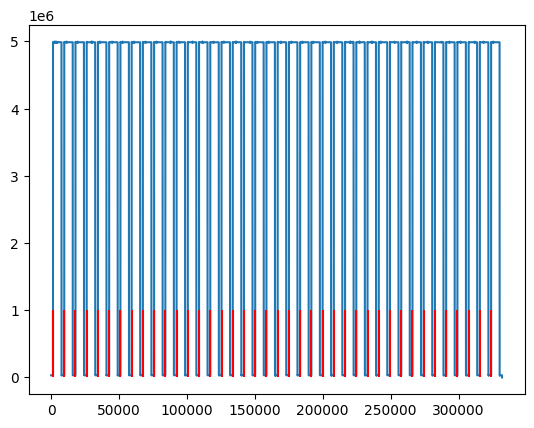

In [79]:
plt.plot(picture)
plt.vlines(peaks, ymin=0, ymax=1e6, color='r')

In [80]:
idx = 42

# slice data at picture onset - 0.5s to picture onset + 1.5s
slices = []
for i in peaks:
    slices.append(data[:, i - int(0.5*sampling_rate):i + int(1.5*sampling_rate)])
slices = np.array(slices)


In [81]:
from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time


coh = spectral_connectivity_epochs(
    slices, method='coh', mode='fourier',
    sfreq=sampling_rate, fmin=2, fmax=250, faverage=True, n_jobs=10)
freqs = coh.freqs


Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 7626 connections
    using t=0.000s..2.000s for estimation (4096 points)
    frequencies: 2.0Hz..250.0Hz (497 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..10


/tmp/ipykernel_184480/3526157014.py:4: RuntimeWarning: fmin=2.000 Hz corresponds to 4.000 < 5 cycles based on the epoch length 2.000 sec, need at least 2.500 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  coh = spectral_connectivity_epochs(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    1.0s remaining:    1.4s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    1.4s remaining:    0.6s


    computing connectivity for epochs 11..20


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    1.5s remaining:    0.6s


    computing connectivity for epochs 21..30


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.6s


    computing connectivity for epochs 31..40


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.8s finished


    assembling connectivity matrix
[Connectivity computation done]


In [82]:
results = coh.get_data('dense')

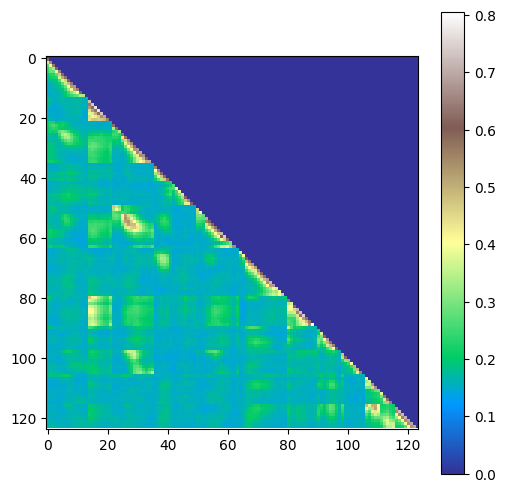

In [83]:
# loop through all colormaps so I can see which one I like best
# spectral
# jet
# hsv
# nipy_specral
# terrain
# Set1
# Tab10


plt.figure(figsize=(6,6))
plt.imshow(np.squeeze(results), cmap='terrain',
            aspect='equal', origin='upper')
plt.colorbar()
plt.show()


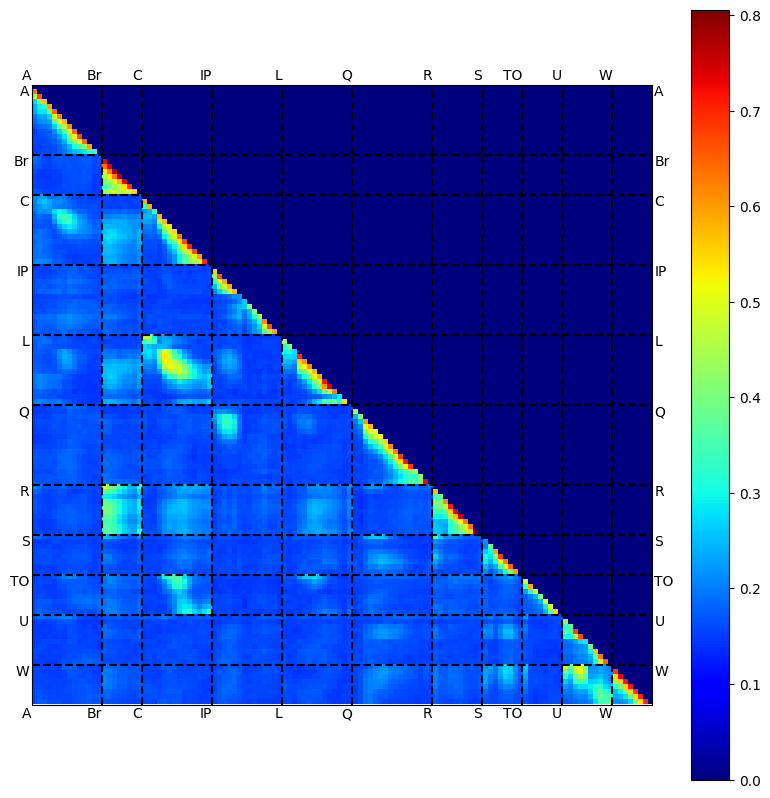

In [84]:
plt.figure(figsize=(10,10))
plt.imshow(results, cmap="jet")
# put a vertical line every time the electrode changes and label it outside the plot
for x,i in enumerate(indices):
    plt.axvline(i, color="k", linestyle="--")
    plt.text(i, -1, uniq_ec[x], rotation=0, va="bottom", ha="right")
    # put text on bottom of plot
    plt.text(i, results.shape[0], uniq_ec[x], rotation=0, va="top", ha="right")

# put a horizontal line every time the electrode changes and label it outside the plot
for x,i in enumerate(indices):
    plt.axhline(i, color="k", linestyle="--")
    plt.text(-1, i, uniq_ec[x], rotation=0, va="top", ha="right")
    # put text on right side of plot
    plt.text(results.shape[1], i, uniq_ec[x], rotation=0, va="top", ha="left")

# remove the ticks
plt.xticks([])
plt.yticks([]);
plt.colorbar()


In [85]:
# color map of unique color for each electrode
colors = plt.cm.tab10(np.linspace(0, 1, len(uniq_ec)))
map = dict(zip(uniq_ec, colors))
# add default color
map['default'] = 'k'

/tmp/ipykernel_184480/767975279.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df["X"]*-1, df["Y"], df["Z"], c=map[i], label=i)


Text(0.5, 0, 'Z')

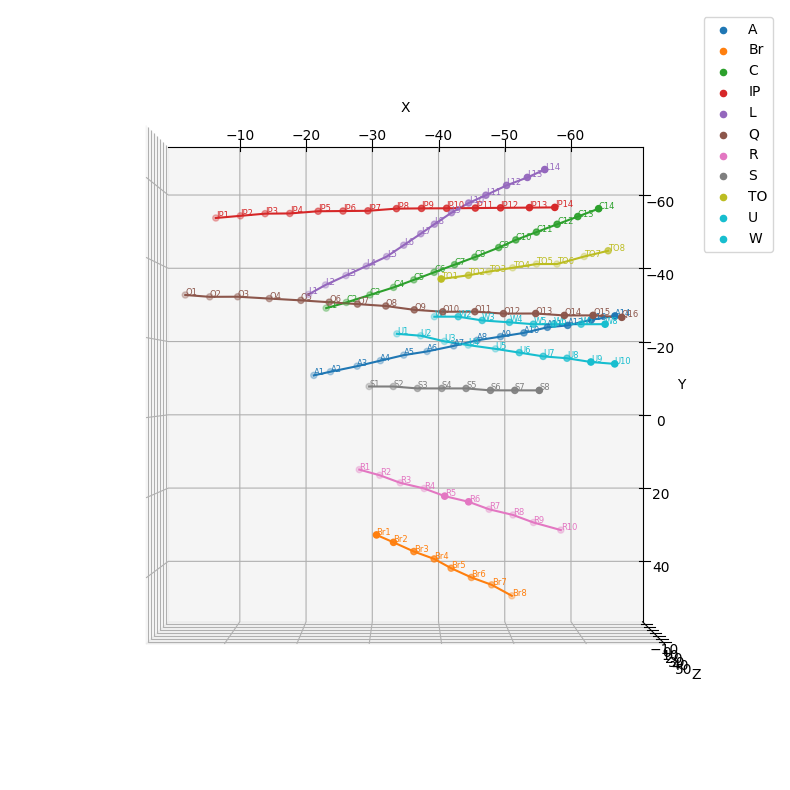

In [86]:
import pandas as pd
threed_data = pd.read_csv("/media/dan/Data/data/iEEG/raw_ieeg/patientDumps/FC/Deformation/LabelXYZAtlases.csv")
# remove "EEG " from Electrode name
threed_data["Electrode"] = threed_data["Electrode"].apply(lambda x: x[4:])
# extract the electrode contact from the electrode name (non-numeric characters)
threed_data["Electrode Contact"] = threed_data["Electrode"].apply(get_contact)
threed_data.head()


# plot 3d scatter plot of electrode locations. do 3 axes one for each dimension
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for i in uniq_ec:
    df = threed_data[threed_data["Electrode Contact"] == i]
    ax.scatter(df["X"]*-1, df["Y"], df["Z"], c=map[i], label=i)
    # plot connecting lines
    ax.plot(df["X"]*-1, df["Y"], df["Z"], c=map[i])

    # put small text labels on each electrode
    for x, y, z, s in zip(df["X"]*-1, df["Y"], df["Z"], df["Electrode"]):
        ax.text(x, y, z, s, fontsize=6, color=map[i])
ax.legend()

#rotate
ax.view_init(azim=90, elev=90)
# label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

/tmp/ipykernel_184480/1194010998.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_top.scatter(df["X"]*-1, df["Y"], df["Z"], c=map.get(i, map['default']), label=i)
/tmp/ipykernel_184480/1194010998.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_side_x.scatter(df["X"]*-1, df["Y"]*-1, df["Z"], c=map.get(i, map['default']), label=i)
/tmp/ipykernel_184480/1194010998.py:38: UserWarning: *c* argument looks like a sin

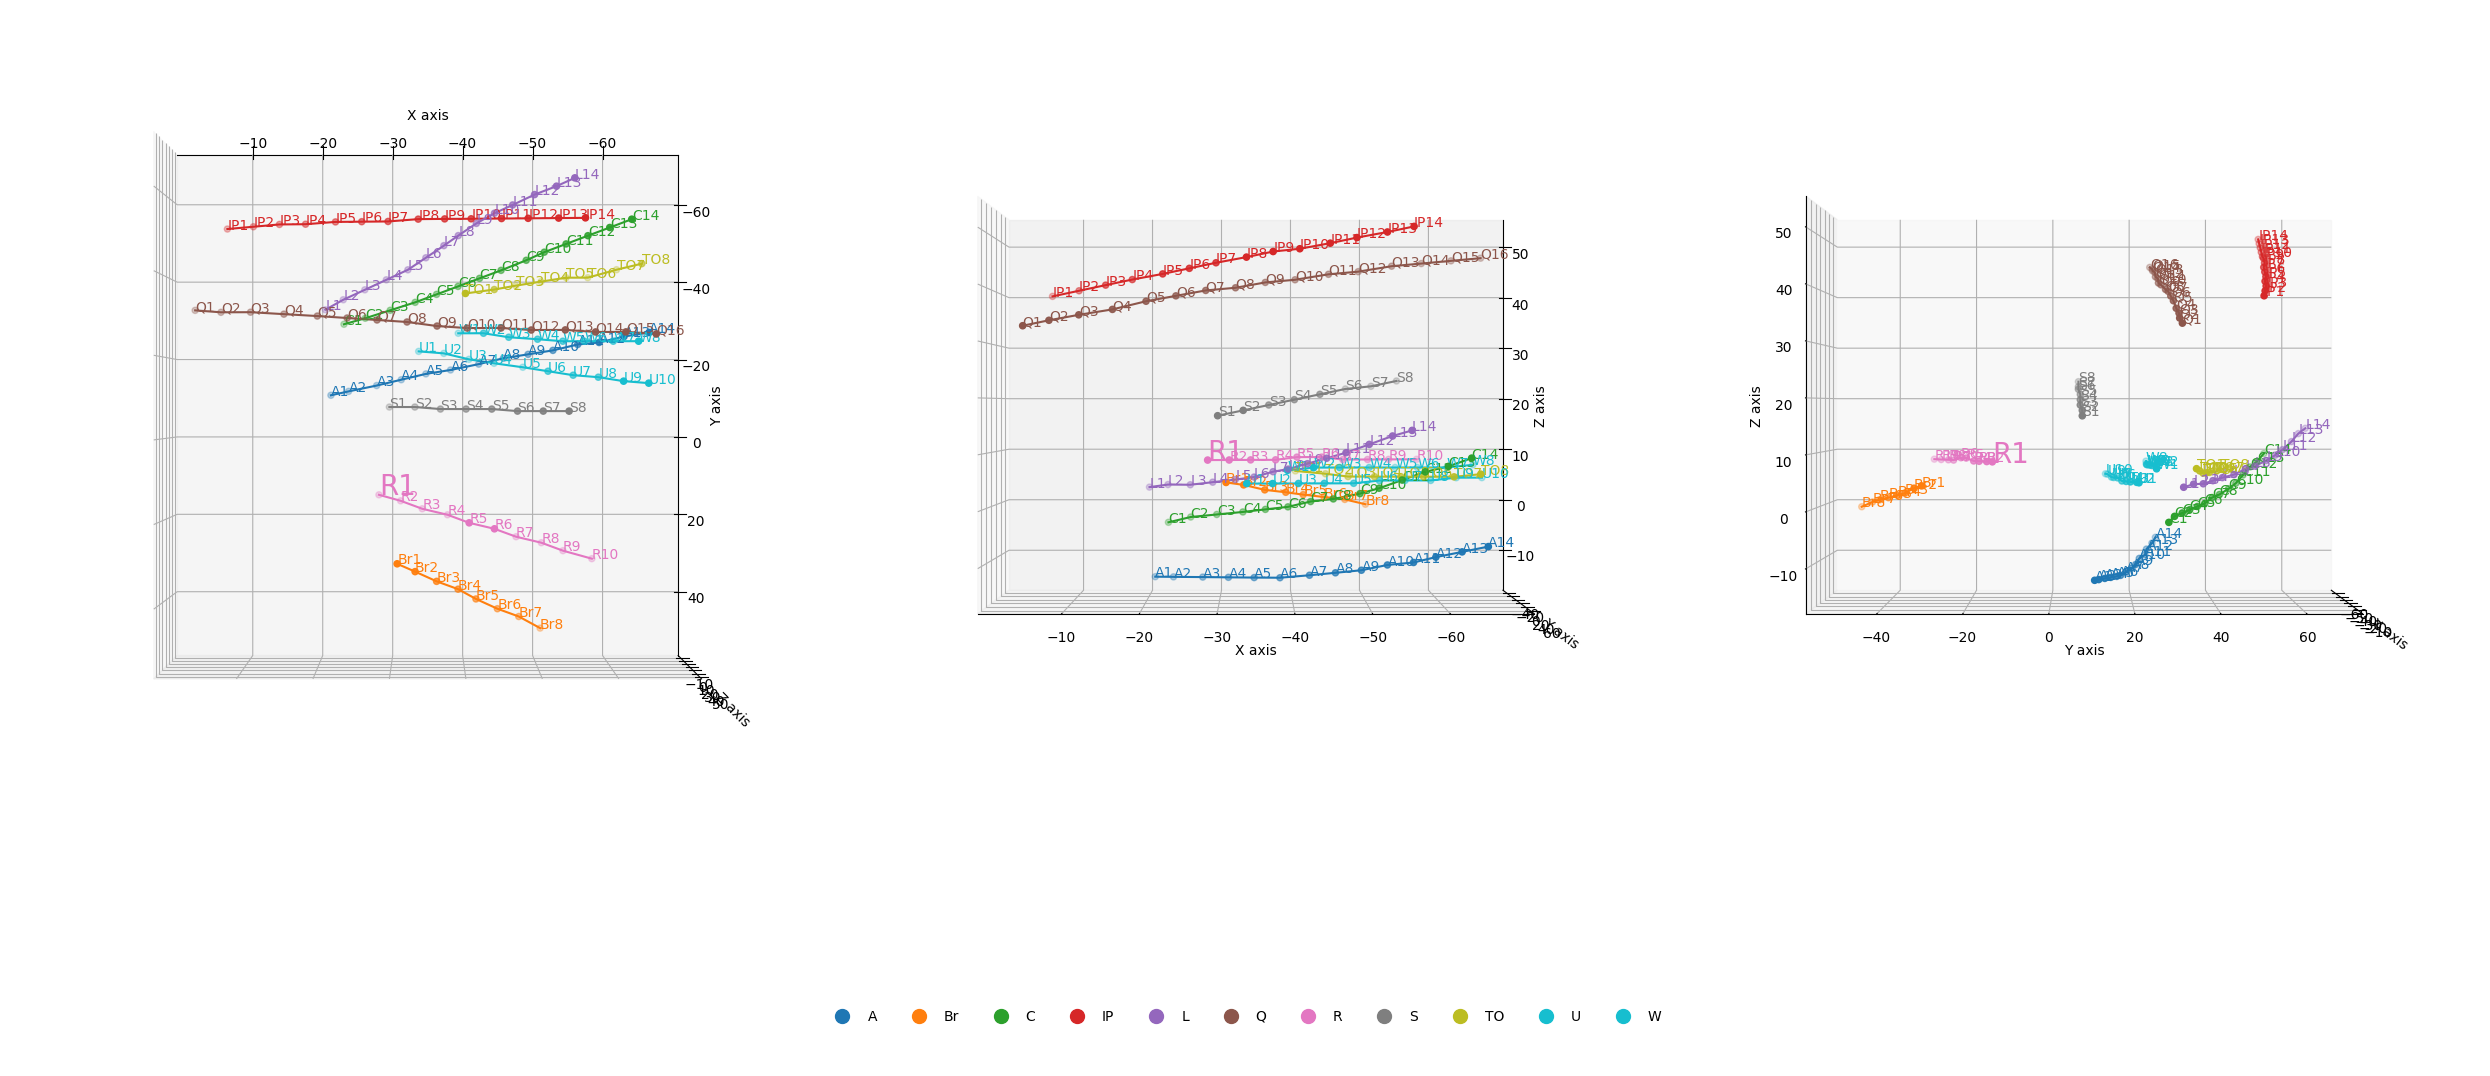

In [87]:
# Adjust the code to fix the issues and generate the correct layout for the plots.

# Create a new figure with the intended layout: one large plot on top and two smaller plots below
fig = plt.figure(figsize=(25, 10))

label_of_intrest = "R1"
label_of_intrest_size = 20

font_size = 10
# Top view (Z axis) - Large upper plot
ax_top = fig.add_subplot(1, 3, 1, projection='3d')
for i in uniq_ec:
    df = threed_data[threed_data["Electrode Contact"] == i]
    ax_top.scatter(df["X"]*-1, df["Y"], df["Z"], c=map.get(i, map['default']), label=i)
    ax_top.plot(df["X"]*-1, df["Y"], df["Z"], c=map.get(i, map['default']))
    for x, y, z, s in zip(df["X"]*-1, df["Y"], df["Z"], df["Electrode"]):
        if s == label_of_intrest:
            ax_top.text(x, y, z, s, fontsize=label_of_intrest_size, color=map.get(i, map['default']))
        else:
            ax_top.text(x, y, z, s, fontsize=font_size, color=map.get(i, map['default']))


ax_side_x = fig.add_subplot(1,3,2, projection='3d')
for i in uniq_ec:
    df = threed_data[threed_data["Electrode Contact"] == i]
    ax_side_x.scatter(df["X"]*-1, df["Y"]*-1, df["Z"], c=map.get(i, map['default']), label=i)
    ax_side_x.plot(df["X"]*-1, df["Y"]*-1, df["Z"], c=map.get(i, map['default']))
    for x, y, z, s in zip(df["X"]*-1, df["Y"]*-1, df["Z"], df["Electrode"]):
        if s == label_of_intrest:
            ax_side_x.text(x, y, z, s, fontsize=label_of_intrest_size, color=map.get(i, map['default']))
        else:
            ax_side_x.text(x, y, z, s, fontsize=font_size, color=map.get(i, map['default']))

# # Front view (Y axis) - Bottom right plot, looking down Y
ax_front_y = fig.add_subplot(1,3,3, projection='3d')
for i in uniq_ec:
    df = threed_data[threed_data["Electrode Contact"] == i]
    ax_front_y.scatter(df["X"]*-1, df["Y"]*-1, df["Z"], c=map.get(i, map['default']), label=i)
    ax_front_y.plot(df["X"]*-1, df["Y"]*-1, df["Z"], c=map.get(i, map['default']))
    for x, y, z, s in zip(df["X"]*-1, df["Y"]*-1, df["Z"], df["Electrode"]):
        if s == label_of_intrest:
            ax_front_y.text(x, y, z, s, fontsize=label_of_intrest_size, color=map.get(i, map['default']))
        else:
            ax_front_y.text(x, y, z, s, fontsize=font_size, color=map.get(i, map['default']))


# Adjust the view angles for side and front plots to look down the X and Y axes respectively
ax_top.view_init(elev=90, azim=90)
ax_side_x.view_init(elev=0, azim=90)
ax_front_y.view_init(elev=0, azim=0)

# Set the labels for the axes
ax_top.set_xlabel('X axis')
ax_top.set_ylabel('Y axis')
ax_top.set_zlabel('Z axis')

ax_side_x.set_xlabel('X axis')
ax_side_x.set_ylabel('Y axis')
ax_side_x.set_zlabel('Z axis')

ax_front_y.set_xlabel('X axis')
ax_front_y.set_ylabel('Y axis')
ax_front_y.set_zlabel('Z axis')

# Remove the color warnings by specifying the 'color' keyword
plt.tight_layout()

# put legend below all the plots


# Add a legend with dummy scatter points representing each unique electrode contact
legend_ax = fig.add_axes([0.1, -0.15, 0.8, 0.1], frameon=False)  # Add an axes for the legend
legend_ax.axis('off')  # Turn off the axes frame and ticks

# Plot dummy scatter points for the legend
for i in uniq_ec:
    legend_ax.scatter([], [], s=100, c=map.get(i, map['default']), label=f'{i}')

# Place the legend in the added axes
legend_ax.legend(loc='center', ncol=len(uniq_ec), frameon=False)

# Show the final figure
plt.show()

In [88]:
# # make 3 sine waves two of which are in phase and one of which is out of phase
# x = np.linspace(0, 2*np.pi, int(sampling_rate*40))

# # increase the frequency of the sine waves
# test = []
# for x in range(10):
#     test.append(np.sin(x*40*np.linspace(0, 2*np.pi, int(sampling_rate*20))))
# test= np.array(test)

# # cut into epochs of sampling_rate length
# peaks = np.arange(0,test.shape[1], int(sampling_rate)).astype(int)
# peaks = peaks[1:-1]
# # slice data at picture onset - 0.5s to picture onset + 1.5s
# slices = []
# for i in peaks:
#     slices.append(test[:, i - int(0.5*sampling_rate):i + int(1.5*sampling_rate)])

# slices = np.array(slices)
# mne.set_config('MNE_MEMMAP_MIN_SIZE', '100M') 
# mne.set_config('MNE_CACHE_DIR', '/dev/shm')

# stest = spectral_connectivity_time(slices, freqs=np.arange(40,100), method='coh', sfreq=sampling_rate, faverage=True, n_jobs=55)
# plt.figure(figsize=(6,6))
# x = stest.get_data('dense').squeeze()
# for i in range(x.shape[0]):
#     plt.imshow(x[i,...], cmap='terrain',
#                 aspect='equal', origin='upper')
#     plt.colorbar()
#     plt.show()
